# <center> **ПРОГНОЗИРОВАНИЕ БИОЛОГИЧЕСКОГО ОТВЕТА (HW-3)**

### Условие задачи
Необходимо предсказать биологический ответ молекул (столбец *'Activity'*) по их химическому составу (столбцы *D1-D1776*).

### Импортируем библиотеки

In [1]:
import numpy as np # для матричных вычислений
import pandas as pd # для анализа и предобработки данных
import matplotlib.pyplot as plt # для визуализации
import seaborn as sns # для визуализации

from time import time
from sklearn import linear_model # линейные моделиё
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression # логистическая регрессия
from sklearn.model_selection import GridSearchCV # поиск параметров по сетке
from sklearn.model_selection import RandomizedSearchCV # рандомизированный поиск
from sklearn import tree # деревья решений
from sklearn import ensemble # ансамбли
from sklearn import metrics # метрики
from sklearn import preprocessing # предобработка
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split # сплитование выборки
import hyperopt
from hyperopt import hp, fmin, tpe, Trials
import optuna

%matplotlib inline
plt.style.use('seaborn')

### Загружаем данные

In [2]:
# Загружаем датасет
data = pd.read_csv('Прочие файлы/_train_sem09 (1).csv')

# Создаём копию
data_copy = data.copy()

In [ ]:
# Выводим первые пять строк
data_copy.head()

Разделим набор данных на матрицу наблюдений X и вектор ответов y:

In [3]:
# Матрица наблюдений X
X = data.drop(columns='Activity', axis=1)

# Вектор правильных ответов
y = data['Activity']

Разделим выборку на тренировочную и тестовую в соотношении 80/20. Используем разбиение, стратифицированное по целевому признаку.

In [4]:
# Делим данные с помощью параметра stratify
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

## Оптимизация гиперпараметров модели

### **Логистическая регрессия**

Приступим сразу к оптимизации гиперпараметров алгоритма логистической регрессии. Зафиксируем только те метрики, которые были получены без дополнительной настройки, то есть со значениями гиперпараметров, установленных по умолчанию:

In [ ]:
# Создаем объект класса логистическая регрессия
log_reg = linear_model.LogisticRegression(max_iter = 1000)

# Обучаем модель, минимизируя logloss
log_reg.fit(X_train, y_train)
print('accuracy на тестовом наборе: {:.2f}'.format(log_reg.score(X_test, y_test)))

y_test_pred = log_reg.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

Теперь вызовем класс **GridSearchCV** и передадим модель (*LogisticRegression*), сетку искомых параметров (*param_grid*), а также число фолдов, которые мы хотим использовать в кросс-валидации, и *n_jobs = -1*, чтобы использовать все доступные ядра для расчётов:

In [ ]:
param_grid = {
    'penalty': ['l2', 'none'], # тип регурялизации
    'solver': ['lbfgs', 'saga'] # алгоритм оптимизации
}

grid_search = GridSearchCV(
    estimator = linear_model.LogisticRegression(random_state = 1, max_iter = 1000),
    param_grid = param_grid,
    cv = 5,
    n_jobs = -1
)

# %time - замеряет время выполнения
%time grid_search.fit(X_train, y_train)
print('accuracy на тестовом наборе: {:.2f}'. format(grid_search.score(X_test, y_test)))

y_test_pred = grid_search.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print('Наилучшие значения гиперпараметров: {}'.format(grid_search.best_params_))

Метрику улучшить не удалось, попробуем расширить сетку параметров

In [ ]:
param_grid = [
    
    {'penalty': ['l2', 'None'], # тип регуляризации
     'solver': ['lbfgs', 'sag'], # алгоритм оптимизации
     'C': [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1]}, # уровень силы регуляризации,
    
    {'penalty': ['l1', 'l2'],
     'solver': ['liblinear', 'saga'],
     'C': [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1]}
    
]

grid_search_1 = GridSearchCV(
    estimator = linear_model.LogisticRegression(random_state = 1, max_iter = 1000),
    param_grid = param_grid,
    cv = 5,
    n_jobs = -1
)

# %time - замеряет время выполнения
%time grid_search_1.fit(X_train, y_train)
print('accuracy на тестовом наборе: {:.2f}'.format(grid_search_1.score(X_test, y_test)))

y_test_pred = grid_search_1.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print('Наилучшие значения гиперпараметров: {}'.format(grid_search_1.best_params_))

Построим тепловую карту, в ней отрисуем, как менялась метрика при различных гиперпараметрах.

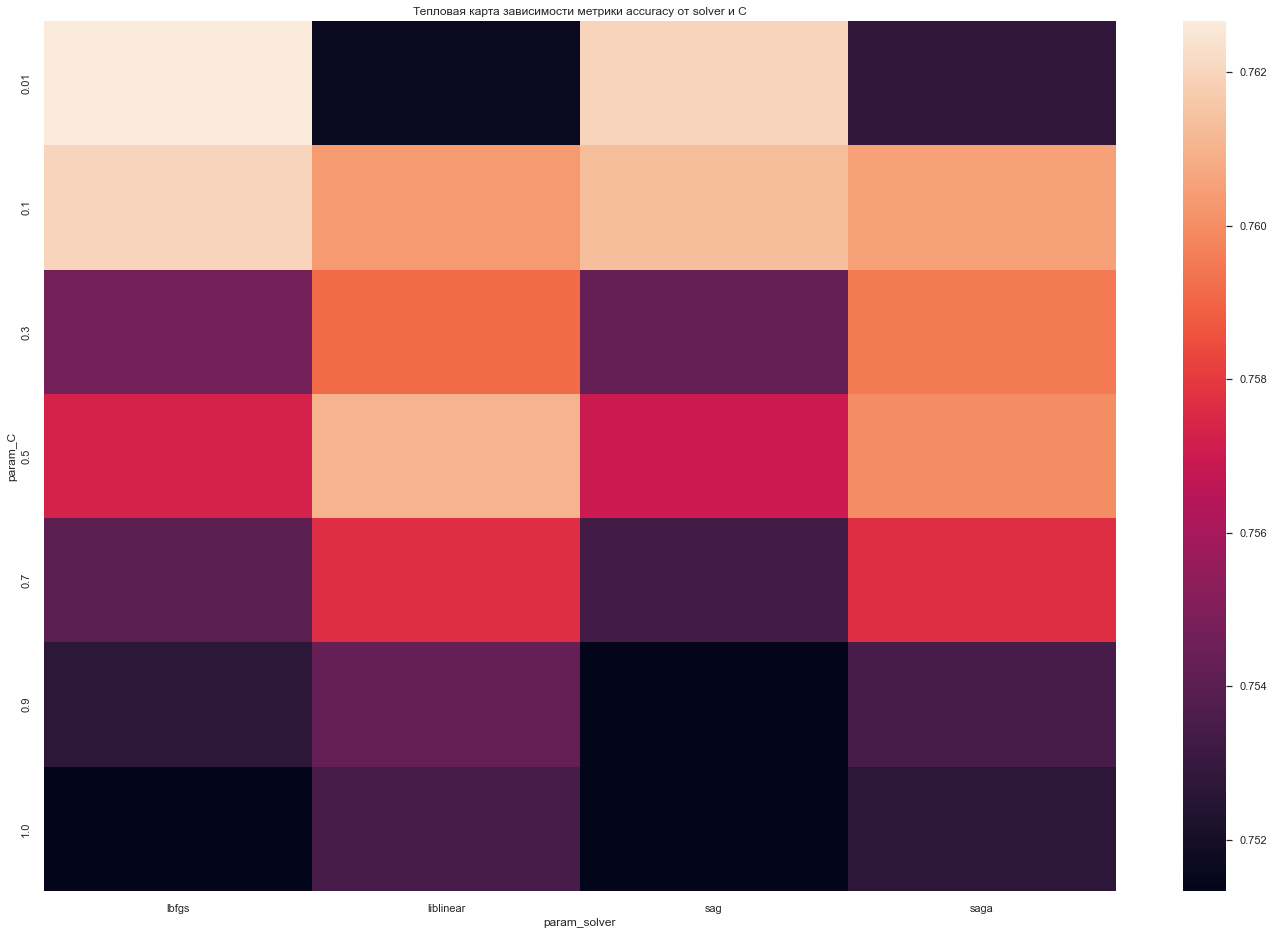

In [18]:
visual = pd.pivot_table(
    data = pd.DataFrame(grid_search_1.cv_results_),
    values = 'mean_test_score',
    index = 'param_C',
    columns = 'param_solver'
)

sns.heatmap(visual)
plt.title('Тепловая карта зависимости метрики accuracy от solver и C') # подпись графика
sns.set(rc = {'figure.figsize': (24, 16)}) # задаем размер графика

In [ ]:
param_grid = {
    'penalty': ['l2', 'None'],
    'solver': ['lbfgs', 'sag'],
    'C': list(np.linspace(0.1, 0.5, dtype=float))
},

grid_search_2 = GridSearchCV(
    estimator = linear_model.LogisticRegression(random_state = 42, max_iter = 1000),
    param_grid = param_grid,
    cv = 5,
    n_jobs = -1
)

%time grid_search_2.fit(X_train, y_train)
print('accuracy на тестовом наборе: {:.2f}'.format(grid_search_2.score(X_test, y_test)))

y_test_pred = grid_search_2.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print('Наилучшие значения гиперпараметров: {}'.format(grid_search_2.best_params_))

**Вывод:** 

Из полученных результатов следует, что с подобранными параметрами метрику удалось улучшить на 0.01 как на accuracy, так и на f1_score.

А теперь проделаем всё ту же работу с помощью класса **RandomizedSearchCV**

In [ ]:
# np.linspace(start(от), stop(до), num=50(количество),dtype-тип данных)
param_distributions = {
    'penalty': ['l2', 'None'],
    'solver': ['lbfgs', 'sag'],
    'C': list(np.linspace(0.1, 0.5, 10, dtype = float))
}

random_search = RandomizedSearchCV(
    estimator = linear_model.LogisticRegression(random_state = 42, max_iter = 1000),
    param_distributions = param_distributions,
    cv = 5,
    n_iter = 10,
    n_jobs = -1
)

%time random_search.fit(X_train, y_train)
print('accuracy на тестовом наборе: {:.2f}'.format(random_search.score(X_test, y_test)))

y_test_pred = random_search.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print('Наилучшие значения гиперпараметров: {}'.format(random_search.best_params_))

**Вывод:** 

Из полученных результатов можно сделать вывод, что с аналогичными параметрами класс *RandomizedSearchCV* значительно сокращает время подбора параметров, но при этом из метрик удалось улучшить только метрику f1_score на 0.01, и значение которой составило 0.79

### **Случайный лес**

Проделаем аналогичные шаги для RandomForestClassifier().
Сначала посчитаем модель с параметрами по умолчанию и оценим метрику:

In [ ]:
# Создаем объект класса случайный лес
rand_forest = ensemble.RandomForestClassifier(random_state = 42)

# Обучаем модель
rand_forest.fit(X_train, y_train)

# Выводим значения метрики
y_train_pred = rand_forest.predict(X_train)
print('Train: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))

y_test_pred = rand_forest.predict(X_test)
print('Test: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

Теперь зададим сетку гиперпараметров: 

*   'n_estimators' - количество деревьев в лесу, по умолчанию =100

*  'min_samples_leaf' - минимальное количество объектов в листе;
*  'max_depth': максимальная глубина дерева, не должна быть слишком большой, иначе будет переобучение;




И посчитаем *RandomizedSearchCV()* и затем *GridSearchCV()*

In [ ]:
param_distributions = {
    'n_estimators': list(range(80, 200, 30)),
    'min_samples_leaf': [5],
    'max_depth': list(np.linspace(20, 40, 10, dtype=int))
}

random_search_forest = RandomizedSearchCV(
    estimator = ensemble.RandomForestClassifier(random_state = 42),
    param_distributions = param_distributions,
    cv = 5,
    n_iter = 10,
    n_jobs = -1
)

%time random_search_forest.fit(X_train, y_train)
y_train_pred = random_search_forest.predict(X_train)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
print('accuracy на тестовом наборе: {:.2f}'.format(random_search_forest.score(X_test, y_test)))

y_test_pred = random_search_forest.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print('Наилучшие значения гиперпараметров: {}'.format(random_search_forest.best_params_))

In [ ]:
param_grid = {
    'n_estimators': list(range(80, 200, 30)),
    'min_samples_leaf': [5],
    'max_depth': list(np.linspace(20, 40, 5, dtype=int))
}

grid_search_forest = GridSearchCV(
    estimator = ensemble.RandomForestClassifier(random_state = 42),
    param_grid = param_grid,
    cv = 5,
    n_jobs = -1
)

%time grid_search_forest.fit(X_train, y_train)
y_train_pred = grid_search_forest.predict(X_train)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
print('accuracy на тестовом наборе: {:.2f}'.format(grid_search_forest.score(X_test, y_test)))

y_test_pred = grid_search_forest.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print('Наилучшие значения гиперпараметров: {}'.format(grid_search_forest.best_params_))

**Вывод:** 

Из расчётов *RandomizedSearchCV()* и *GridSearchCV()* мы видим, что метрики *accuracy* и *f1_score* на тестовом наборе не изменились, однако метрика *f1_score* на обучающем наборе показала наилучший результат (0.95 у *RandomizedSearchCV* против 0.94 у *GridSearchCV*), а так же время на подбор гиперпараметров у *RandomizedSearchCV()* заняло значительно меньше, чем у *GridSearchCV()*.

## **Продвинутая оптимизация.**

### <center> HYPEROPT

### **Логистическая регрессия**

In [44]:
penalty = ['l2', None]
solver = ['lbfgs', 'saga']

# Зададим пространство поиска гиперпараметров
space = {
    'penalty': hp.choice('penalty', ['l2', None]), # тип регуляризации
    'solver': hp.choice('solver', ['lbfgs', 'saga']), # алгоритм оптимизации
    'C': hp.uniform('C', low = 0.1, high = 0.5) # уровень силы регурялизации
}

In [45]:
# Зафксируем random_state
random_state = 42

def hyperopt_lg(params, cv=5, X=X_train, y=y_train, random_state=random_state):
    
    # Функция получает комбинацию гиперпараметров в "params"
    params = {
        'penalty': params['penalty'],
        'solver': params['solver'],
        'C': float(params['C'])
    }
    
    # Используем логистическую регрессию для построения модели
    model = linear_model.LogisticRegression(**params, random_state=random_state, max_iter=1000)
    
    # Обучаем модель
    model.fit(X, y)
    score = metrics.f1_score(y, model.predict(X))
    
    # Метрику необходимо минимизировать, поэтому ставим знак минус
    return -score

In [ ]:
%%time
trials = Trials() # используется для логирования результатов

best = fmin(
    hyperopt_lg, # наша функция
    space = space, # пространство гиперпараметров
    algo = tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
    max_evals = 20, # максимальное количество итераций
    trials = trials, # логирование результатов
    rstate = np.random.default_rng(random_state) # фиксируем для повторяемости результата
)

print('Наилучшие значения гиперпараметров {}'.format(best))

In [ ]:
# Рассчитаем точность для тестовой выборки
model = linear_model.LogisticRegression(
    random_state = random_state,
    penalty = penalty[best['penalty']],
    solver = solver[best['solver']],
    C = float(best['C'])
)

model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
print('accuracy на тестовом наборе: {:.2f}'.format(model.score(X_test, y_test)))

y_test_pred = model.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

Попробуем увеличить количество итераций

In [ ]:
%%time
trials = Trials() # используется для логирования результатов

best = fmin(
    hyperopt_lg, # наша функция
    space = space, # пространство гиперпараметров
    algo = tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
    max_evals = 23, # максимальное количество итераций
    trials = trials, # логирование результатов
    rstate = np.random.default_rng(random_state) # фиксируем для повторяемости результата
)

print('Наилучшие значения гиперпараметров {}'.format(best))

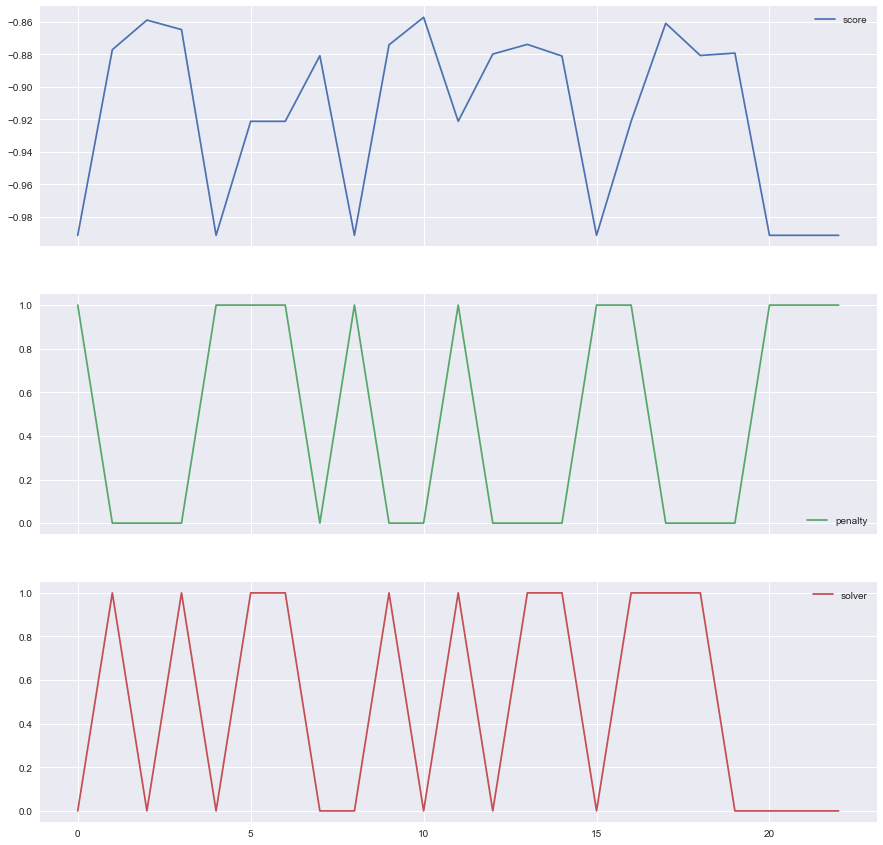

In [35]:
# Отрисуем, как менялась точность при различных гиперпараметрах
tpe_results = np.array(
    [[
        x['result']['loss'],
        x['misc']['vals']['penalty'][0],
        x['misc']['vals']['solver'][0]
    ] for x in trials.trials]
)

tpe_results_df = pd.DataFrame(
    data = tpe_results,
    columns = ['score', 'penalty', 'solver']
)

# Тепловая карта в данном случае не очень наглядна, возьмем линейный график
tpe_results_df.plot(subplots=True, figsize=(15, 15));

По графикам видно, что лучшая точность достигается именно в **best_params**. Однако метрика отрицательная, так как нам необходимо максимизировать нашу метрику, в то время как *Hyperopt* может только минимизировать.

In [ ]:
# Рассчитаем точность для тестовой выборки
model = linear_model.LogisticRegression(
    random_state = random_state,
    penalty = penalty[best['penalty']],
    solver = solver[best['solver']],
    C = float(best['C'])
)

model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
print('accuracy на тестовом наборе: {:.2f}'.format(model.score(X_test, y_test)))

y_test_pred = model.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

### **Случайный лес**

In [51]:
# Зададим пространство поиска гиперпараметров
space = {
    'n_estimators': hp.quniform('n_estimators', 100, 200, 1),
    'max_depth': hp.quniform('max_depth', 15, 26, 1),
    'min_samples_leaf': hp.quniform('min_samples_leaf', 2, 10, 1)
}

In [52]:
# Зафксируем random_state
random_state = 42

def hyperopt_rf(params, cv=5, X=X_train, y=y_train, random_state=random_state):
    
    # Функция получает комбинацию гиперпараметров в "params"
    params = {
        'n_estimators': int(params['n_estimators']),
        'max_depth': int(params['max_depth']),
        'min_samples_leaf': int(params['min_samples_leaf'])
    }
    
    # Используем эту комбинацию для построения модели
    model = ensemble.RandomForestClassifier(**params, random_state=random_state)
    
    # Обучаем модель
    model.fit(X, y)
    score = metrics.f1_score(y, model.predict(X))
    
    # Метрику необходимо минимизировать, поэтому ставим знак минус
    return -score

In [ ]:
%%time
trials = Trials() # Используется для логирования результатов

best = fmin(
    hyperopt_rf, # наша функция
    space = space, # пространство гиперпараметров
    algo = tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
    max_evals = 20, # максимальное количество итераций
    trials = trials, # логирование результатов
    rstate = np.random.default_rng(random_state) # фиксируем для повторяемости результата
)

print('Наилучшие значения гиперпараметров {}'.format(best))

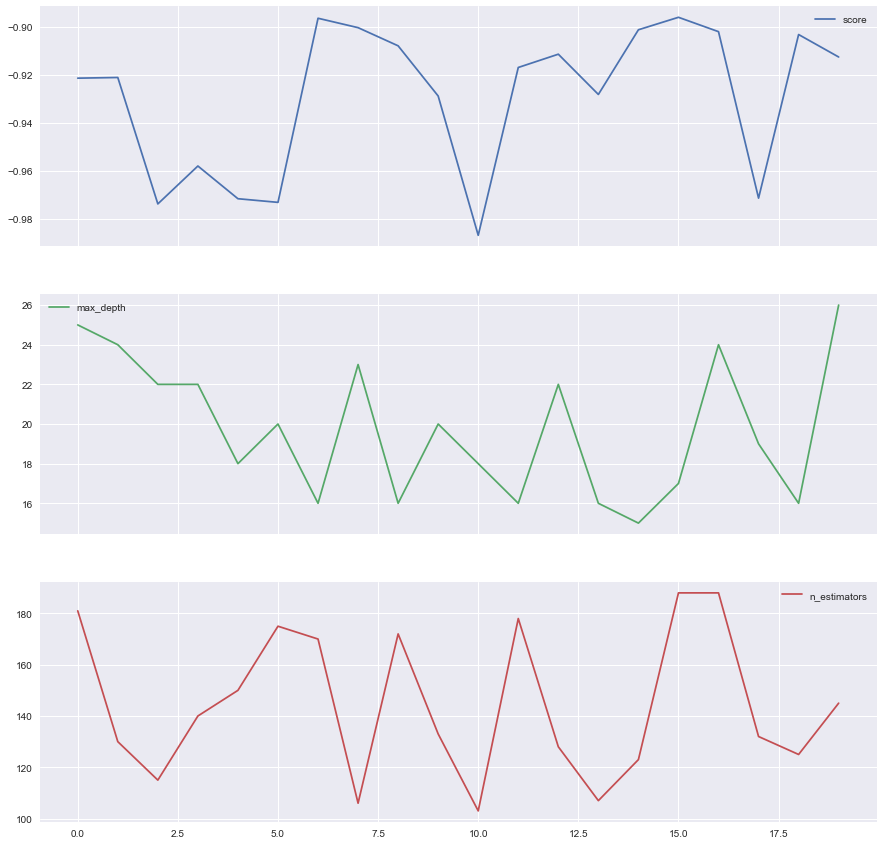

In [40]:
# Отрисуем, как менялась точность при различных гиперпараметрах
tpe_results = np.array(
    [[
        x['result']['loss'],
        x['misc']['vals']['max_depth'][0],
        x['misc']['vals']['n_estimators'][0]
    ] for x in trials.trials]
)

tpe_results_df = pd.DataFrame(
    data = tpe_results,
    columns = ['score', 'max_depth', 'n_estimators']
)

# Тепловая карта в данном случае не очень наглядна, возьмем линейный график
tpe_results_df.plot(subplots=True, figsize=(15, 15));

Всё тоже самое, что и в случае с логистической регрессией: лучшая точность достигается в **best_params**. Однако метрика отрицательная.

In [ ]:
# Рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(
    random_state = random_state,
    n_estimators = int(best['n_estimators']),
    max_depth = int(best['max_depth']),
    min_samples_leaf = int(best['min_samples_leaf'])
)

model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
print('accuracy на тестовом наборе: {:.2f}'.format(model.score(X_test, y_test)))

y_test_pred = model.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

## <center> Optuna

### **Логистическая регрессия**

Настроим оптимизацию гиперпараметров для алгоритма логистической регрессии

In [9]:
# Зафксируем random_state
random_state = 42

def optuna_lg(trial):
    
    # Задаем пространства поиска гиперпараметров
    params = {
        'penalty': trial.suggest_categorical('penalty', ['l2', None]), # тип регуляризации
        'solver': trial.suggest_categorical('solver', ['lbfgs', 'saga']), # алгоритм оптимизации
        'C': trial.suggest_float('C', low = 0.1, high = 0.5) # уровень силы регурялизации
    }

    # Используем логистическую регрессию для построения модели
    model = linear_model.LogisticRegression(**params, random_state=random_state, max_iter=1000)
    
    # Oбучаем модель
    model.fit(X_train, y_train)
    score = metrics.f1_score(y_train, model.predict(X_train))
    
    return score

In [ ]:
%%time

# Cоздаем объект исследования
# Можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study_lg = optuna.create_study(study_name = 'LogisticRegression', direction = 'maximize')

# Ищем лучшую комбинацию гиперпараметров n_trials раз
study_lg.optimize(optuna_lg, n_trials = 20)

In [ ]:
# Выводим результаты на обучающей выборке
print('Наилучшие значения гиперпараметров {}'.format(study_lg.best_params))
print('f1_score на обучающем наборе: {:.2f}'.format(study_lg.best_value))

In [ ]:
# Рассчитаем точность для тестовой выборки
model = linear_model.LogisticRegression(**study_lg.best_params, random_state = random_state)
model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
print('accuracy на тестовом наборе: {:.2f}'.format(model.score(X_test, y_test)))

y_test_pred = model.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

Строим график истории оптимизации

In [13]:
optuna.visualization.plot_optimization_history(study=study_lg, target_name = 'f1_score')

Судя по построенной диаграмме все идет верно, метрика максимизируется.

Строим график важности гиперпараметров

In [14]:
optuna.visualization.plot_param_importances(study=study_lg, target_name='f1_score')

Из этого графика можно сделать вывод, что стоит обратить большее внимание на настройку гиперпараметра penalty

### **Случайный лес**

Настроим оптимизацию гиперпараметров для алгоритма случайного леса.

In [24]:
def optuna_rf(trial):
    
    # Задаем пространства поиска гиперпараметров
    n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
    max_depth = trial.suggest_int('max_depth', 10, 30, 1)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)
    
    # Cоздаем модель
    model = ensemble.RandomForestClassifier(
        n_estimators = n_estimators,
        max_depth = max_depth,
        min_samples_leaf = min_samples_leaf,
        random_state = random_state
    )
    
    # Oбучаем модель
    model.fit(X_train, y_train)
    score = metrics.f1_score(y_train, model.predict(X_train))
    
    return score

In [ ]:
%%time

# Cоздаем объект исследования
# Можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study_rf = optuna.create_study(study_name = 'RandomForestClassifier', direction = 'maximize')

# Ищем лучшую комбинацию гиперпараметров n_trials раз
study_rf.optimize(optuna_rf, n_trials = 20)

In [ ]:
# Выводим результаты на обучающей выборке
print('Наилучшие значения гиперпараметров {}'.format(study_rf.best_params))
print('f1_score на обучающем наборе: {:.2f}'.format(study_rf.best_value))

In [ ]:
# Рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(**study_rf.best_params, random_state = random_state)
model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
print('accuracy на тестовом наборе: {:.2f}'.format(model.score(X_test, y_test)))

y_test_pred = model.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

Строим график истории оптимизации

In [28]:
optuna.visualization.plot_optimization_history(study=study_rf, target_name='f1_score')

Судя по построенной диаграмме видно, что метрика также максимизируется.

Строим график важности гиперпараметров

In [29]:
optuna.visualization.plot_param_importances(study=study_rf, target_name='f1_score')

Из этого графика можно сделать вывод, что стоит обратить большее внимание на настройку гиперпараметра min_samples_leaf

### **Вывод:**

Если сравнить результаты оптимизации обоих классов, то мы видим следующее:



**HYPEROPT**

Логистическая регрессия:

- *f1_score* на обучающем наборе: 0.91
- *accuracy* на тестовом наборе: 0.73
- *f1_score* на тестовом наборе: 0.76
- *Wall time*: 4min 27s


Случайный лес:

- *f1_score* на обучающем наборе: 0.99
- *accuracy* на тестовом наборе: 0.79
- *f1_score* на тестовом наборе: 0.81
- *Wall time*: 34.1 s



**OPTUNA**

Логистическая регрессия:

- *f1_score* на обучающем наборе: 0.99
- *accuracy* на тестовом наборе: 0.73
- *f1_score* на тестовом наборе: 0.76
- *Wall time*: 3min 23s


Случайный лес:

- *f1_score* на обучающем наборе: 0.99
- *accuracy* на тестовом наборе: 0.78
- *f1_score* на тестовом наборе: 0.80
- *Wall time*: 42.4 s


Из полученных данных мы можем заключить, что наилучшие результаты (как по полученным метрикам, так и по скорости выполнения оптимизации) достигаются при обучении модели случайного леса: метрики на тестовом наборе выше в среднем на 0.04, а скорость обучения в 4 раза выше.